# ABS Quarterly Consumer Price Index 6401

## Python set-up

In [1]:
# system imports
import sys
import pathlib  
import calendar
import re
from typing import Optional, Dict, List, Tuple

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

# local imports
from plotting import (
    finalise_plot,
    set_chart_dir,
    recalibrate_series,
    clear_chart_dir,
    plot_growth_finalise,
)    
from abs_data_capture import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    find_id,
    clear_cache,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '6401'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction to a DataFrame
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
clear_chart_dir(CHART_DIR) # top expenditue item charts are uniquely named
set_chart_dir(CHART_DIR)

### Headline CPI for Australia - Annual+Quarterly

In [5]:
# Used for pattern matching retrieval 

quarterly_phrase = 'Percentage Change from Previous Period'
annual_phrase = 'Percentage Change from Corresponding Quarter of Previous Year'
aus_phrase = 'Australia'

desc_col = 'Data Item Description'
type_col = 'Series Type'
table_col = 'Table'

None


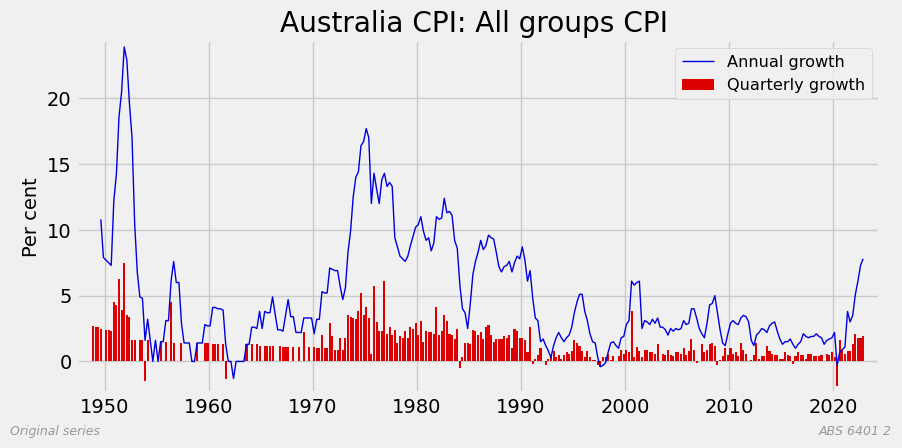

2017-09-01 00:00:00


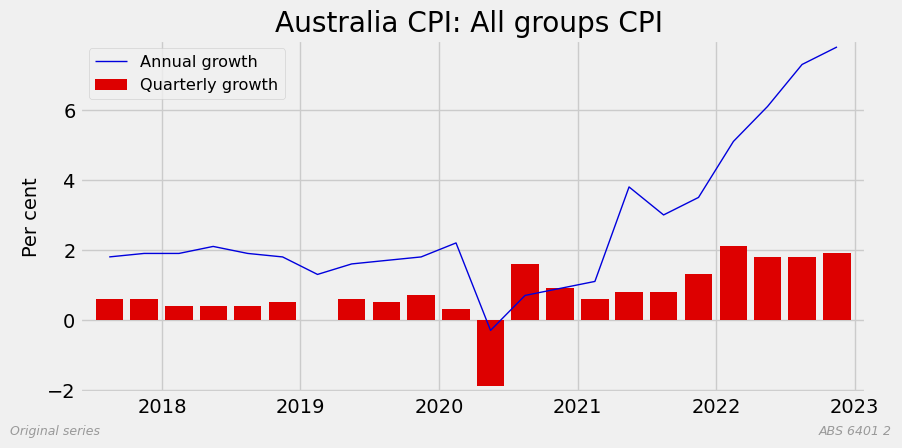

In [6]:
table = '2'
data = abs_dict[table]
series_type = 'Original'
title = 'All groups CPI ;  Australia'

# get data identifiers
label = 'All groups CPI '
a_id, _ = find_id(meta, {table: table_col, series_type:type_col, 
                   annual_phrase:desc_col, label:desc_col, 
                   aus_phrase:desc_col})
q_id, _ = find_id(meta, {table: table_col, series_type:type_col, 
                   quarterly_phrase:desc_col, label:desc_col, 
                   aus_phrase:desc_col})

# plot
for plot_from, plot_tag in zip(plot_times, plot_tags):
    print(plot_from)
    p_plot_from = None if plot_from is None else pd.Period(plot_from, freq=data.index.freq)
    plot_growth_finalise(
        data[a_id], data[q_id], 
        from_=p_plot_from, 
        title=f'Australia CPI: {label}', 
        tag=plot_tag, 
        rfooter=f'{source} {table}',
        lfooter=f'{series_type.capitalize()} series',
        show=True
    )

In [7]:
# Latest annual
data[a_id].tail()

Series ID
2021Q4    3.5
2022Q1    5.1
2022Q2    6.1
2022Q3    7.3
2022Q4    7.8
Freq: Q-DEC, Name: A2325847F, dtype: float64

In [8]:
# Latest qty
data[q_id].tail() #.rolling(window=4).sum().tail(), 

Series ID
2021Q4    1.3
2022Q1    2.1
2022Q2    1.8
2022Q3    1.8
2022Q4    1.9
Freq: Q-DEC, Name: A2325850V, dtype: float64

In [9]:
# prdictive assuming next quarter is the same as last quarter
round(data[q_id][-3:].sum() + data[q_id][-1], 1)

7.4

In [10]:
# predictive assuming 2.5 percent next quarter
round(data[q_id][-3:].sum() + 2.5, 1)

8.0

### Trimmed Mean / Weighted Median - Seas Adj - Annual+Quarterly

In [11]:
table = '8'
data = abs_dict[table]
series_type = 'Seasonally Adjusted'

for label in ('Trimmed Mean', 'Weighted Median', 
              'All groups CPI', 
              "All groups CPI excluding 'volatile items'",
              'All groups CPI excluding food and energy'):
    
    series_type = 'Seasonally Adjusted' if 'excluding' not in label else 'Original'
    
    a_id, _ = find_id(meta, {table: table_col, series_type:type_col, 
                          annual_phrase:desc_col, label:desc_col})
    q_id, _ = find_id(meta, {table: table_col, series_type:type_col, 
                          quarterly_phrase:desc_col, label:desc_col})
    
    title = f'CPI Australia: {label}'
    
    for plot_from, plot_tag in zip(plot_times, plot_tags):
        p_plot_from = None if plot_from is None else pd.Period(plot_from, freq=data.index.freq)
        plot_growth_finalise(
            data[a_id], data[q_id], 
            from_=p_plot_from, 
            title=title, 
            tag=f'-{series_type.replace(" ", "-")}{plot_tag}', 
            rfooter=f'{source} {table}',
            lfooter=series_type,
            #show=True,
        )

### Inflation over the long run ...

"... the target for monetary policy in Australia is to achieve an inflation rate of 2–3 per cent, on average, over time."

In [12]:
def annualise_percentages(series:pd.Series, periods:int=4) -> pd.Series:
    """Annualise a growth rate for a period."""
    
    s = series / 100. 
    annual = (((1 + s) ** periods) - 1) * 100 
    return annual

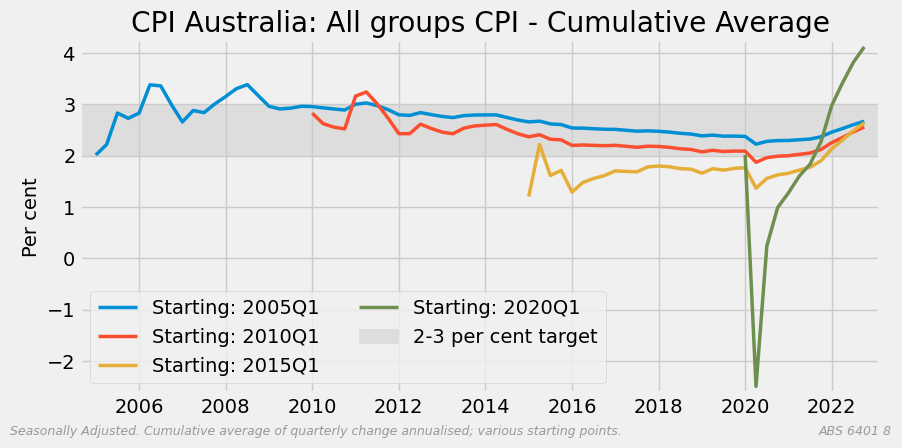

In [13]:
table = '8'
data = abs_dict[table].copy()
series_type = 'Seasonally Adjusted'

for label in (
    #'Trimmed Mean', 
    'All groups CPI',
):
    q_id, _ = find_id(meta, {table: table_col, 
                             series_type:type_col, 
                             quarterly_phrase:desc_col, 
                             label:desc_col})
    series = data[q_id].dropna()

    # Averages - different starting points    
    a_frame = pd.DataFrame()
    for start in ['2005-01-01', '2010-01-01',
                  '2015-01-01', '2020-01-01', ]:
        start_period = pd.Period(start, freq='Q')
        a_frame[f'Starting: {start_period}'] = (
            series[series.index >= start_period]
            .apply(annualise_percentages)
        )
    a_frame = a_frame.cumsum() / a_frame.notna().cumsum()
    ax = a_frame.plot(lw=2.5)
    ax.axhspan(2, 3, color='#dddddd', label='2-3 per cent target', zorder=-1)
    ax.legend(title=None, loc='best', ncol=2)
    finalise_plot(
        ax, 
        title=f'CPI Australia: {label} - Cumulative Average', 
        ylabel='Per cent', 
        rfooter=f'{source} {table}',
        lfooter=f'{series_type}. '
                'Cumulative average of quarterly change annualised; various starting points.',
        show=True,
    )   
    
    # Rolling averages of different lengths
    r_frame = pd.DataFrame()
    for years in (3, 5, 7, 10): # years
        QTR_PER_YEAR = 4
        r_frame[f'{years}-Year rolling ave.'] = (
            series.rolling(years * QTR_PER_YEAR).mean()
            .apply(annualise_percentages)
        )
    ax = r_frame.plot(lw=2.5)
    ax.axhspan(2, 3, color='#dddddd', label='2-3 per cent target', zorder=-1)
    ax.legend(title=None, loc='best', ncol=2)
    finalise_plot(
        ax, 
        title=f'CPI Australia: {label} - Rolling Averages', 
        ylabel='Per cent', 
        rfooter=f'{source} {table}',
        lfooter=f'{series_type}. Rolling average of quarterly change annualised; various-periods.',
        #show=True,
    )  

### Analytical annual series

In [14]:
table = '8'
data = abs_dict[table]
stem = 'Percentage Change from Corresponding Quarter of Previous Year ;  '
post = ' ;  Australia ;'
groups = [
    ['Tradables', 'Non-tradables'],
    ['Original', 'Seasonally Adjusted'],
    ['Goods', 'Services'],
    ['Trimmed Mean', 'Weighted Median'],
]

# manage long/ugly names
replacements = {
    'Goods': 'All groups, goods component',
    'Services': 'All groups, services component',
    'Original': 'All groups CPI',
    'Seasonally Adjusted': 'All groups CPI, seasonally adjusted',
}

for dataset in groups:
    idents = []
    for title in dataset:
        if title in replacements:
            title = replacements[title]
        description = f'{stem}{title}{post}'
        series_type = ('Seasonally Adjusted' if 'season' in title 
                            or 'Trimmed' in title
                            or 'Weighted' in title
                       else 'Original'
                      )
        search = {
            table: table_col,
            description: desc_col,
            series_type: type_col,
        }
        ident, units = find_id(meta, search)
        idents.append(ident)
        
    for start, tag in zip(plot_times, plot_tags):
        df = data[data.index >= pd.Period(start, freq=data.index.freq)] if start else data
        pair = df[idents]
        pair = pair.dropna(how='all', axis=0)
        pair.columns = dataset
        ax = pair.plot(lw=2, color=['blue', 'darkorange'])
        ax.axhspan(2, 3, color='#dddddd', label='2-3% target', zorder=-1)
        ax.legend(loc='best', ncol=2)
        finalise_plot(
            ax, 
            title=f'CPI Australia: {", ".join(dataset)}', 
            ylabel=units, 
            tag=tag, 
            rfooter=f'{source} {table}',
            lfooter='Per cent change from same quarter in previous year',
            #show=True,
        )

### Expenditure groups, sub-groups and classes

#### Map of groups, sub-groups, classses

In [15]:
expenditure_groups = {
    'Food and non-alcoholic beverages', 'Alcohol and tobacco', 'Clothing and footwear', 'Housing',
    'Furnishings, household equipment and services', 'Health', 'Transport', 'Communication',
    'Recreation and culture', 'Education', 'Insurance and financial services',
}

expenditure_sub_groups = {
    'Bread and cereal products', 'Meat and seafoods', 'Dairy and related products', 'Fruit and vegetables',
        'Food products n.e.c.', 'Non-alcoholic beverages', 'Meals out and take away foods',
    'Alcoholic beverages', 'Tobacco',
    'Garments', 'Footwear', 'Accessories and clothing services', 
    'Rents', 'New dwelling purchase by owner-occupiers', 'Other housing', 'Utilities',
    'Furniture and furnishings', 'Household textiles', 'Household appliances, utensils and tools', 
        'Non-durable household products', 'Domestic and household services', 
    'Medical products, appliances and equipment', 'Medical, dental and hospital services', 
    'Private motoring', 'Urban transport fares',
    'Communication',
    'Audio, visual and computing equipment and services', 'Newspapers, books and stationery', 
        'Holiday travel and accommodation', 'Other recreation, sport and culture',
    'Education',
    'Insurance', 'Financial services',
}

expenditure_classes = {
    'Bread', 'Cakes and biscuits', 'Breakfast cereals', 'Other cereal products', 
    'Beef and veal', 'Pork', 'Lamb and goat', 'Poultry', 'Other meats', 'Fish and other seafood',
    'Milk', 'Cheese', 'Ice cream and other dairy products',
    'Fruit', 'Vegetables',
    'Eggs', 'Jams, honey and spreads', 'Food additives and condiments', 'Oils and fats', 
        'Snacks and confectionery', 'Other food products n.e.c.',
    'Coffee, tea and cocoa', 'Waters, soft drinks and juices',
    'Restaurant meals', 'Take away and fast foods',
    
    'Spirits', 'Wine', 'Beer',
    'Tobacco',
    
    'Garments for men', 'Garments for women', 'Garments for infants and children',
    'Footwear for men', 'Footwear for women', 'Footwear for infants and children',
    'Accessories', 'Cleaning, repair and hire of clothing and footwear',
    
    'Rents',
    'New dwelling purchase by owner-occupiers',
    'Maintenance and repair of the dwelling', 'Property rates and charges', 
    'Water and sewerage', 'Electricity', 'Gas and other household fuels',
    
    'Furniture', 'Carpets and other floor coverings',
    'Household textiles',
    'Major household appliances', 'Small electric household appliances', 
        'Glassware, tableware and household utensils', 'Tools and equipment for house and garden',
    'Cleaning and maintenance products', 'Personal care products', 'Other non-durable household products',
    'Child care', 'Hairdressing and personal grooming services', 'Other household services',
    
    'Pharmaceutical products', 'Therapeutic appliances and equipment',
    'Medical and hospital services', 'Dental services',
    
    'Motor vehicles', 'Spare parts and accessories for motor vehicles', 'Automotive fuel',
        'Maintenance and repair of motor vehicles', 'Other services in respect of motor vehicles',
    'Urban transport fares',
    
    'Postal services', 'Telecommunication equipment and services',
    
    'Audio, visual and computing equipment', 'Audio, visual and computing media and services',
    'Books', 'Newspapers, magazines and stationery', 
    'Domestic holiday travel and accommodation', 'International holiday travel and accommodation',
    'Equipment for sports, camping and open-air recreation', 'Games, toys and hobbies',
        'Pets and related products', 'Veterinary and other services for pets', 
        'Sports participation', 'Other recreational, sporting and cultural services', 
    
    'Preschool and primary education', 'Secondary education', 'Tertiary education',
    
    'Insurance',
    'Deposit and loan facilities (direct charges)', 'Other financial services'
}

# sanity checks on above maps
print(f'Check count mapped items: {len(expenditure_groups) + len(expenditure_sub_groups) + len(expenditure_classes)}')

# identify any missing
table = '7'
data = abs_dict[table].copy()
index_select = 'Index Numbers'
items = meta[
    (meta['Table'] == table)
    & (meta['Data Item Description'].str.contains(index_select))
]
items = (
    items['Data Item Description']
    .str.replace(';  Australia ;', '')
    .str.replace('Index Numbers ;', '')
    .str.strip()
).to_list()
print(f'Check count ABS columns: {len(items)} - should be one more than above')

print('Missing ...') # should be only "all groups cpi"
_ = [print(i) for i in items 
    if i not in expenditure_classes 
        and i not in expenditure_sub_groups 
        and i not in expenditure_groups]
_ = [print(g) for g in expenditure_groups if g not in items]
_ = [print(sg) for sg in expenditure_sub_groups if sg not in items]
_ = [print(c) for c in expenditure_classes if c not in items]

Check count mapped items: 131
Check count ABS columns: 132 - should be one more than above
Missing ...
All groups CPI


#### Plot annual and quarterly growth by expenditure group

In [16]:
def get_cpi_growth_elements(level:str='class', mode:str='annual'
                           ) -> Optional[pd.DataFrame]:
    #set-up
    table = '7'

    # sanity checks
    modes = ('annual', 'quarterly')
    if mode not in modes:
        print(f'Warning: mode should be one of {modes}')
        return None
    levels = ('group', 'sub-group', 'class')
    if level not in levels:
        print(f'Warning: level should be one of {levels}')
        return None
    
    # compile DataFrame of required data items
    at_level = {'class': expenditure_classes, 
                'sub-group': expenditure_sub_groups,
                'group': expenditure_groups}[level]
    at_mode = {'annual': annual_phrase,
               'quarterly': quarterly_phrase}[mode]
    table = '7'
    
    data = pd.DataFrame()
    for cluster in at_level:
        id_selector = {table: table_col, 
                       at_mode: desc_col, 
                       cluster: desc_col,}

        id, _ = find_id(meta, search_terms=id_selector,
                     validate_unique=False)
        data[cluster] = abs_dict[table][id]

    return data

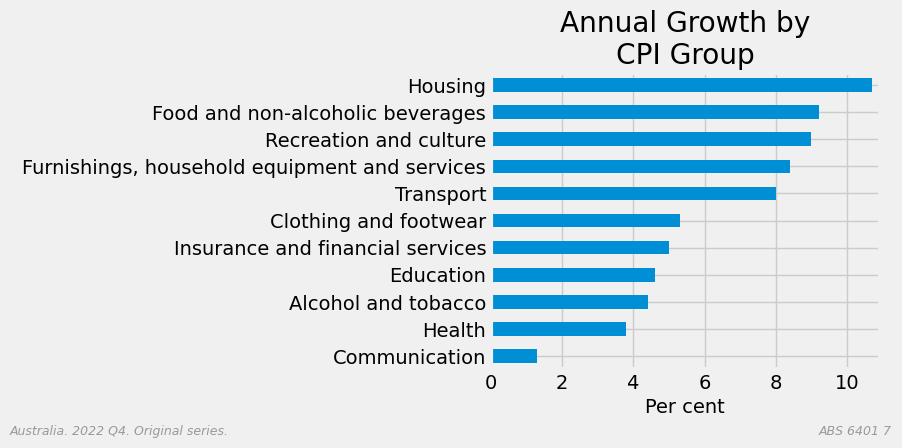

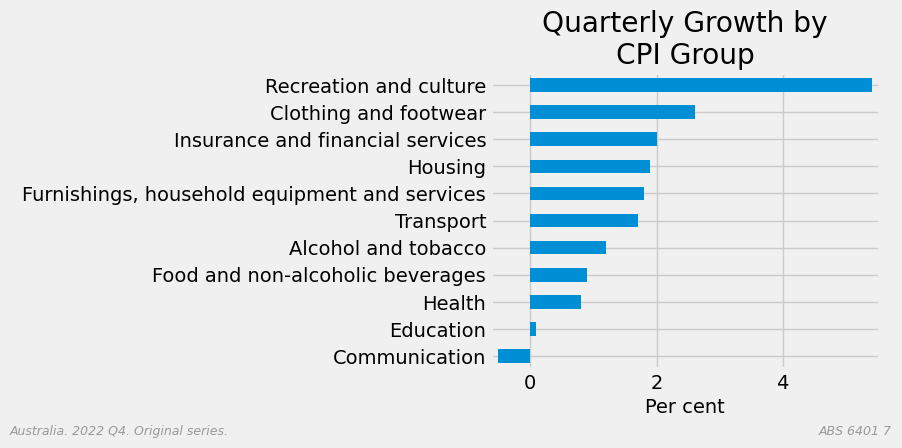

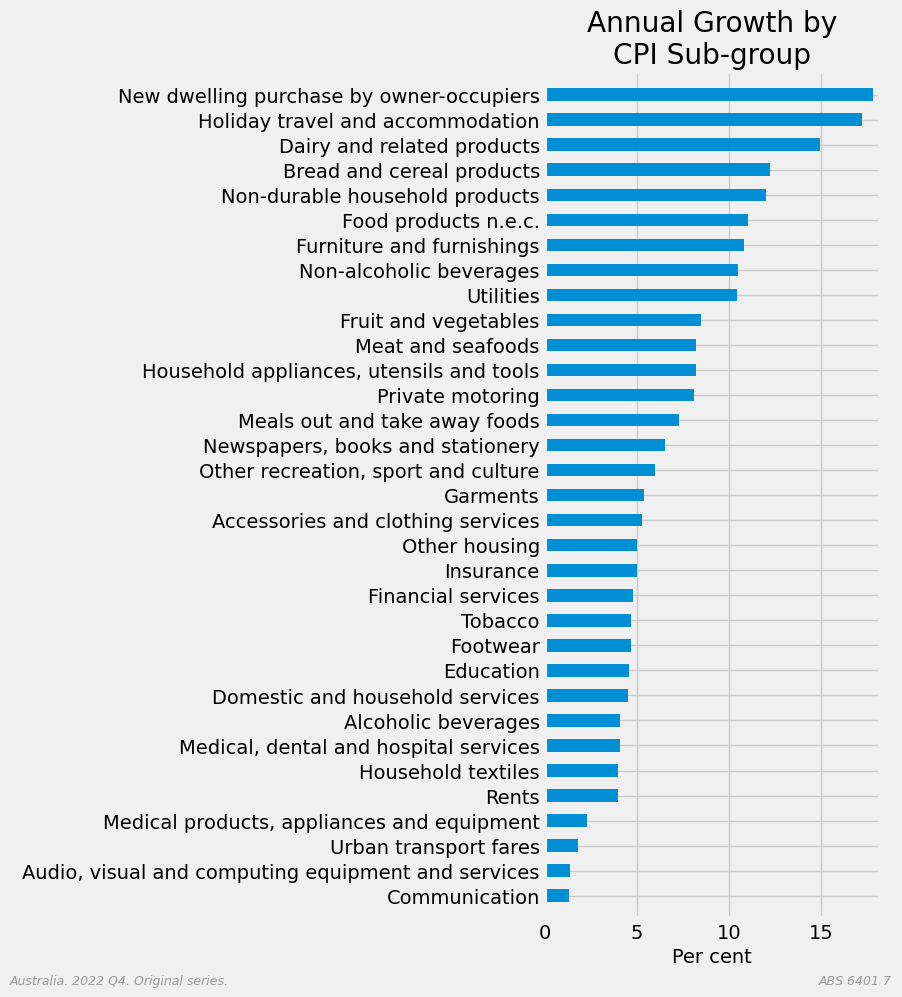

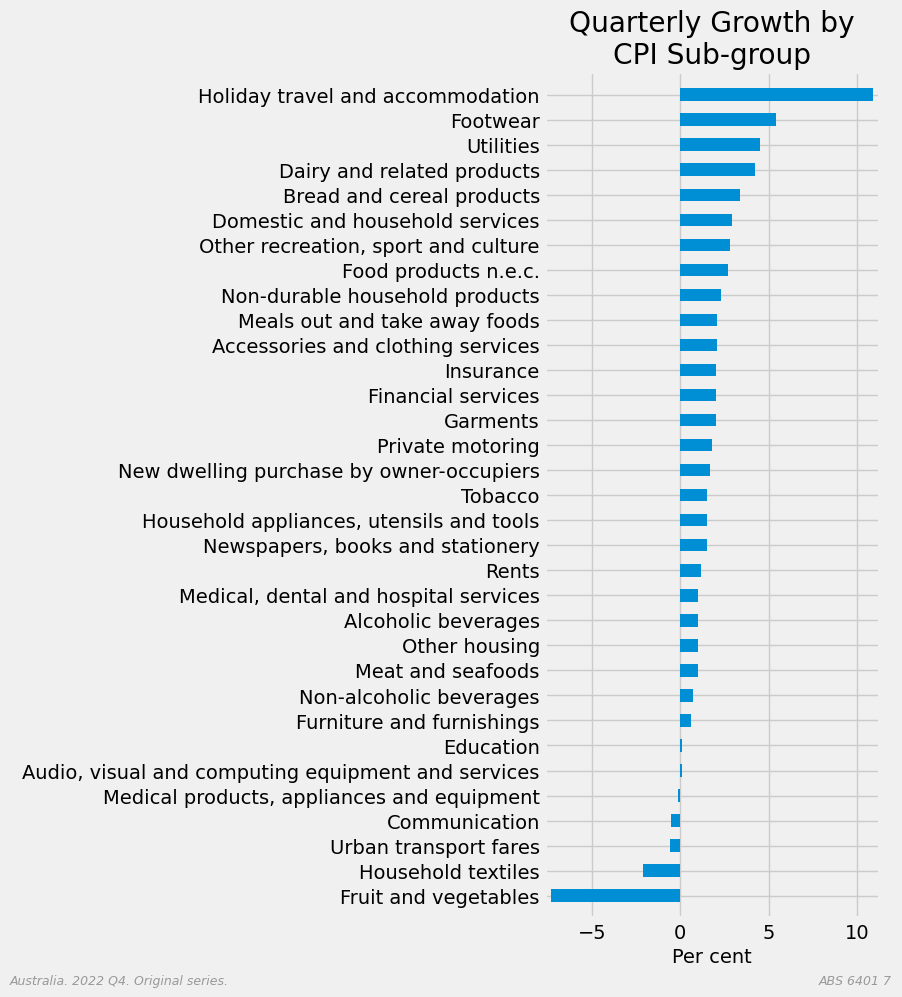

In [17]:
table = '7'

for level in 'group', 'sub-group':
    figsize = (9, 10) if level == 'sub-group' else (9, 4.5)
    for mode in "annual", "quarterly":
    
        data = get_cpi_growth_elements(level=level, mode=mode)
        quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")
        data = data.iloc[-1].sort_values()
    
        ax = data.plot.barh()
        title = f'{mode.capitalize()} Growth by\nCPI {level.capitalize()}'
        finalise_plot(
            ax, 
            title=title,
            xlabel='Per cent',
            rfooter=f'{source} {table}',
            lfooter=f'Australia. {quarter}. Original series.',
            figsize=figsize,
            show=True,
        )

#### Plot top/bottom growing expenditure classes

In [18]:
TOP_KEEP = 20
table = '7'

for mode in "annual", "quarterly":
    
    data = get_cpi_growth_elements(level='class', mode=mode)
    quarter = str(pd.Period(data.index[-1], freq="Q")).replace("Q", " Q")

    for tag in ('top', 'last'):
        subset = (
            data.iloc[-1].sort_values(ascending=True)[-TOP_KEEP:] if tag == 'top'
            else data.iloc[-1].sort_values(ascending=True)[:TOP_KEEP]
        )
        
        ax = subset.plot.barh()
        title = f'{mode.capitalize()} Growth by CPI\nExpenditure Class - {tag} {TOP_KEEP}'
        finalise_plot(
            ax, 
            title=title,
            tag=tag,
            xlabel='Per cent',
            rfooter=f'{source} {table}',
            lfooter=f'Australia. {quarter}. Note: there are {len(expenditure_classes)} expenditure classes',
            figsize=(9, 6),
            #show=True,
        )

#### Breadth of inflation across CPI classes

In [19]:
# set-up
table = '7'
data = get_cpi_growth_elements(level='class', mode='quarterly')
START = pd.Period('1990-01-01', freq=data.index.freq)

# calculate breadth
inflating_count = (data > 0).sum(axis=1, skipna=True)
total = data.notna().sum(axis=1)
breadth = (inflating_count / total * 100)

# plot raw data and smoothed using a moving average.
for moving_ave in 1, 4:
    tag_stem = f'-ma={moving_ave}'
    breadth_ma = breadth.rolling(moving_ave).mean()
    footnote = '' if moving_ave == 1 else f'{moving_ave}-quarter moving average.'
    for plot_from, plot_tag in zip(plot_times, plot_tags):
        start = START if plot_from is None else pd.Period(plot_from, freq=data.index.freq)
        tag = tag_stem + ('' if plot_from is None else '-recent')
        
        plotable = breadth_ma[breadth_ma.index >= start]
        ax = plotable.plot(lw=2.5)
        finalise_plot(
            ax, 
            title=f'CPI: Proportion of classes with Q on Q price growth', 
            ylabel='Per cent', 
            tag=tag,
            rfooter=f'{source} {table}',
            lfooter = 'Australia. Original series.'
                      'CPI Expenditure Classes Only. '
                      f'{footnote}',
            #show=True,
        )

## Finished

In [20]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Feb 22 2023 08:07:46

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.10.0

re         : 2.2.1
matplotlib : 3.7.0
numpy      : 1.24.2
sys        : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
statsmodels: 0.13.5
pandas     : 1.5.3

Watermark: 2.3.1



In [21]:
print('Finished')

Finished
